# Lab5
Библиотеки

In [9]:
from matplotlib import pyplot as plt
import os
import numpy as np
import pandas as pd
import random
from PIL import Image
import torch
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as functional
from torchvision import transforms

Импорт датасета

In [87]:
csv_path = "C:/Users/Yana/Documents/python-v6/Lab2/file.csv"
df = pd.read_csv(csv_path, delimiter=",", names=["Absolute path", "Relative path", "Tag"])
images = df["Absolute path"].to_list()
random.shuffle(images)
print(images)
img_label=[]
for i in range(len(images)):
    img_label.append(os.path.basename(os.path.dirname(images[i])))
print(img_label[:20])

['C:\\Users\\Yana\\Documents\\python-v6\\Lab1\\dataset\\leopard\\0605.jpg', 'C:\\Users\\Yana\\Documents\\python-v6\\Lab1\\dataset\\leopard\\0646.jpg', 'C:\\Users\\Yana\\Documents\\python-v6\\Lab1\\dataset\\tiger\\0571.jpg', 'C:\\Users\\Yana\\Documents\\python-v6\\Lab1\\dataset\\tiger\\0511.jpg', 'C:\\Users\\Yana\\Documents\\python-v6\\Lab1\\dataset\\tiger\\0114.jpg', 'C:\\Users\\Yana\\Documents\\python-v6\\Lab1\\dataset\\leopard\\1240.jpg', 'C:\\Users\\Yana\\Documents\\python-v6\\Lab1\\dataset\\leopard\\0860.jpg', 'C:\\Users\\Yana\\Documents\\python-v6\\Lab1\\dataset\\leopard\\0447.jpg', 'C:\\Users\\Yana\\Documents\\python-v6\\Lab1\\dataset\\leopard\\0633.jpg', 'C:\\Users\\Yana\\Documents\\python-v6\\Lab1\\dataset\\leopard\\1438.jpg', 'C:\\Users\\Yana\\Documents\\python-v6\\Lab1\\dataset\\leopard\\1302.jpg', 'C:\\Users\\Yana\\Documents\\python-v6\\Lab1\\dataset\\leopard\\0190.jpg', 'C:\\Users\\Yana\\Documents\\python-v6\\Lab1\\dataset\\tiger\\0662.jpg', 'C:\\Users\\Yana\\Documents\\pyt

Делим список изображений на тренировочный, тестовый и валидационный

In [88]:
train_list = images[0:int(len(images) * 0.8)]
test_list = images[int(len(images) * 0.8) : int(len(images) * 0.9)]
valid_list = images[int(len(images) * 0.8) : int(len(images) * 0.95)]

print(len(train_list), len(test_list), len(valid_list))

2403 300 450


Проверяем датасет

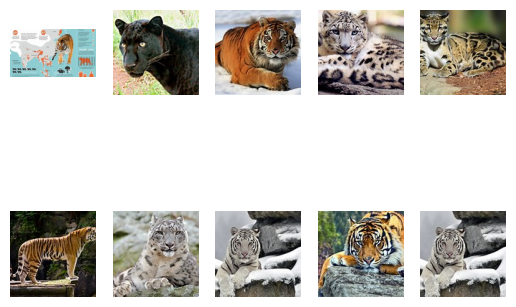

In [89]:
random_idx = np.random.randint(1,len(images),size=10)

fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = Image.open(images[idx])
    plt.imshow(img)
    i+=1
    plt.axis('off')
    
plt.show()

Класс dataset, который хранит загруженные и преобразованные изображения

In [90]:
class dataset(torch.utils.data.Dataset):
    
    def __init__(self,file_list,transform=None):
        self.file_list = file_list
        self.transform = transform
        
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    
def __getitem__(self,index:int):
        img_path = self.dataset[index]
        img = Image.open(img_path)
        img = self.transform(img)
        img_label = []
        for i in range(len(self.dataset)):
            img_label.append(os.path.basename(os.path.dirname(self.dataset[i])))
        label = img_label[index]
        if label == "rose":
            label = 0
        elif label == "tulip":
            label = 1
        return img, label

Формируем набор данных для обучения

In [116]:

fixed_transforms = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    )
train_data = dataset(train_list, transform=fixed_transforms)
test_data = dataset(test_list, transform=fixed_transforms)
val_data = dataset(valid_list, transform=fixed_transforms)


Строим модельку:<br>
    -3 слоя свертки и 2 полносвязных слоя;<br>
    -пакетная нормализация для ограничения переобучения;

In [92]:
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn,self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        
        self.fc1 = nn.Linear(3*3*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        output = self.layer1(x)
        output = self.layer2(output)
        output = self.layer3(output)
        output = output.view(output.size(0),-1)
        output = self.relu(self.fc1(output))
        output = self.fc2(output)
        return output

In [93]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1234)
if device =='cuda':
    torch.cuda.manual_seed_all(1234)
    
model = Cnn().to(device)
model.train()

Cnn(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (re

Рисуем графики

In [94]:
def draw_results(epochs, acc, loss, v_acc, v_loss):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(range(epochs), acc, color="orange", label="Train accuracy")
    ax2.plot(range(epochs), loss, color="orange", label="Train loss")
    ax1.plot(range(epochs), v_acc, color="steelblue", label="Validation accuracy")
    ax2.plot(range(epochs), v_loss, color="steelblue", label="Validation loss")
    ax1.legend()
    ax2.legend()
    plt.show() 

Цикл обучения

In [95]:
def train_loop(epochs, batch_size, lear):
    optimizer = optim.Adam(params = model.parameters(),lr=lear)
    criterion = nn.CrossEntropyLoss()
    epochs = epochs
    accuracy_values = []
    loss_values = []
    val_accuracy_values=[]
    val_loss_values=[]
    val_loader = torch.utils.data.DataLoader(dataset = val_data, 
                                            batch_size=batch_size, 
                                            shuffle=False)
    train_loader = torch.utils.data.DataLoader(dataset = train_data, 
                                            batch_size=batch_size, 
                                            shuffle=True )
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        
        for data, label in train_loader:
            data = data.to(device)
            label = label.to(device)
            
            output = model(data)
            loss = criterion(output, label)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            acc = ((output.argmax(dim=1) == label).float().mean())
            epoch_accuracy += acc/len(train_loader)
            epoch_loss += loss/len(train_loader)
            
        print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))
        accuracy_values.append(epoch_accuracy.item())
        loss_values.append(epoch_loss.item())

        with torch.no_grad():
            epoch_val_accuracy=0
            epoch_val_loss =0
            for data, label in val_loader:
                data = data.to(device)
                label = label.to(device)
                
                val_output = model(data)
                val_loss = criterion(val_output,label)
                
                
                acc = ((val_output.argmax(dim=1) == label).float().mean())
                epoch_val_accuracy += acc/ len(val_loader)
                epoch_val_loss += val_loss/ len(val_loader)
                
            print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))
            val_accuracy_values.append(epoch_val_accuracy.item())
            val_loss_values.append(epoch_val_loss.item()) 
    draw_results(epochs,accuracy_values, loss_values, val_accuracy_values, val_loss_values)

Запускаем обучение

Epoch : 1, train accuracy : 0.8368000388145447, train loss : 0.38491618633270264
Epoch : 1, val_accuracy : 0.9025000333786011, val_loss : 0.40822741389274597
Epoch : 2, train accuracy : 0.9079999327659607, train loss : 0.25673913955688477
Epoch : 2, val_accuracy : 0.6675000190734863, val_loss : 0.599600613117218
Epoch : 3, train accuracy : 0.898666501045227, train loss : 0.23694537580013275
Epoch : 3, val_accuracy : 0.6974999904632568, val_loss : 0.48434796929359436
Epoch : 4, train accuracy : 0.9231998920440674, train loss : 0.21203559637069702
Epoch : 4, val_accuracy : 0.699999988079071, val_loss : 0.8373197317123413
Epoch : 5, train accuracy : 0.9190665483474731, train loss : 0.2018798440694809
Epoch : 5, val_accuracy : 0.6949999928474426, val_loss : 0.4400164484977722
Epoch : 6, train accuracy : 0.9140000939369202, train loss : 0.22113607823848724
Epoch : 6, val_accuracy : 0.6799999475479126, val_loss : 0.3226735591888428
Epoch : 7, train accuracy : 0.9200000166893005, train loss :

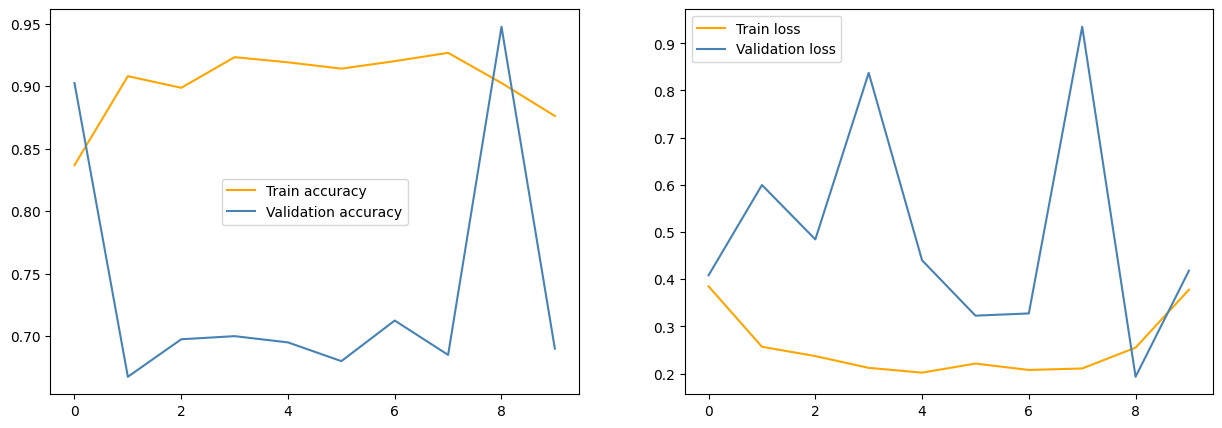

In [1368]:
train_loop(10, 100, 0.001)

Epoch : 1, train accuracy : 0.9185897707939148, train loss : 0.1927298605442047
Epoch : 1, val_accuracy : 0.9277474880218506, val_loss : 0.16826221346855164
Epoch : 2, train accuracy : 0.8852564096450806, train loss : 0.2986046075820923
Epoch : 2, val_accuracy : 0.9353960156440735, val_loss : 0.14820894598960876
Epoch : 3, train accuracy : 0.9028205275535583, train loss : 0.20336619019508362
Epoch : 3, val_accuracy : 0.9006435871124268, val_loss : 0.2376454770565033
Epoch : 4, train accuracy : 0.9369231462478638, train loss : 0.1688993126153946
Epoch : 4, val_accuracy : 0.917896032333374, val_loss : 0.2129213660955429
Epoch : 5, train accuracy : 0.8910256624221802, train loss : 0.24106597900390625
Epoch : 5, val_accuracy : 0.9303464889526367, val_loss : 0.18631993234157562
Epoch : 6, train accuracy : 0.930769145488739, train loss : 0.17990677058696747
Epoch : 6, val_accuracy : 0.9377970099449158, val_loss : 0.1594151258468628
Epoch : 7, train accuracy : 0.9407691955566406, train loss :

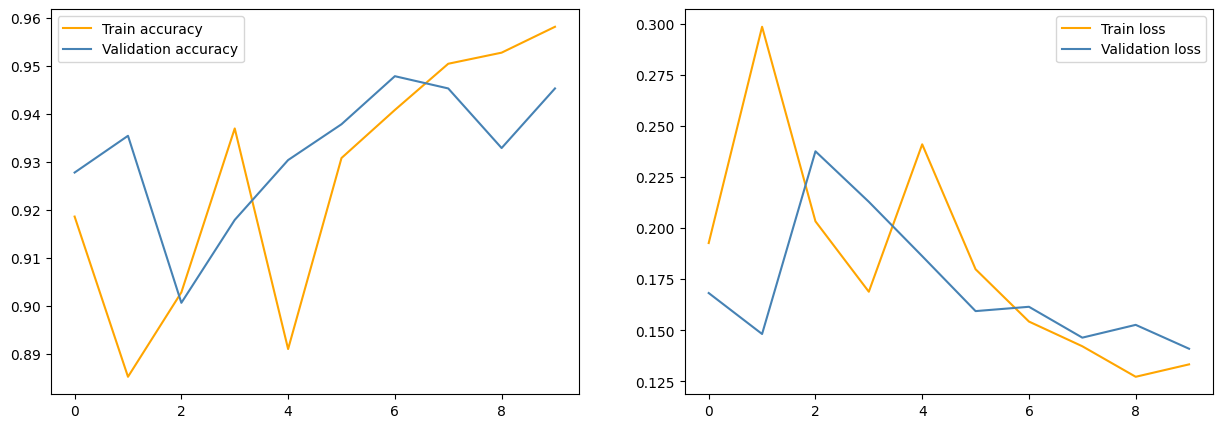

In [1369]:
train_loop(10, 200, 0.001)

Epoch : 1, train accuracy : 0.9177778363227844, train loss : 0.23504559695720673
Epoch : 1, val_accuracy : 0.4699999988079071, val_loss : 0.49278008937835693
Epoch : 2, train accuracy : 0.9137037396430969, train loss : 0.18058744072914124
Epoch : 2, val_accuracy : 0.47333335876464844, val_loss : 1.2205779552459717
Epoch : 3, train accuracy : 0.9507408142089844, train loss : 0.13644860684871674
Epoch : 3, val_accuracy : 0.9666666984558105, val_loss : 0.4194163382053375
Epoch : 4, train accuracy : 0.9140741229057312, train loss : 0.19973036646842957
Epoch : 4, val_accuracy : 0.4750000238418579, val_loss : 0.6044331789016724
Epoch : 5, train accuracy : 0.872963011264801, train loss : 0.22509035468101501
Epoch : 5, val_accuracy : 0.9750000238418579, val_loss : 0.27955955266952515
Epoch : 6, train accuracy : 0.9085184931755066, train loss : 0.17656275629997253
Epoch : 6, val_accuracy : 0.4699999988079071, val_loss : 1.0552575588226318
Epoch : 7, train accuracy : 0.9437037110328674, train lo

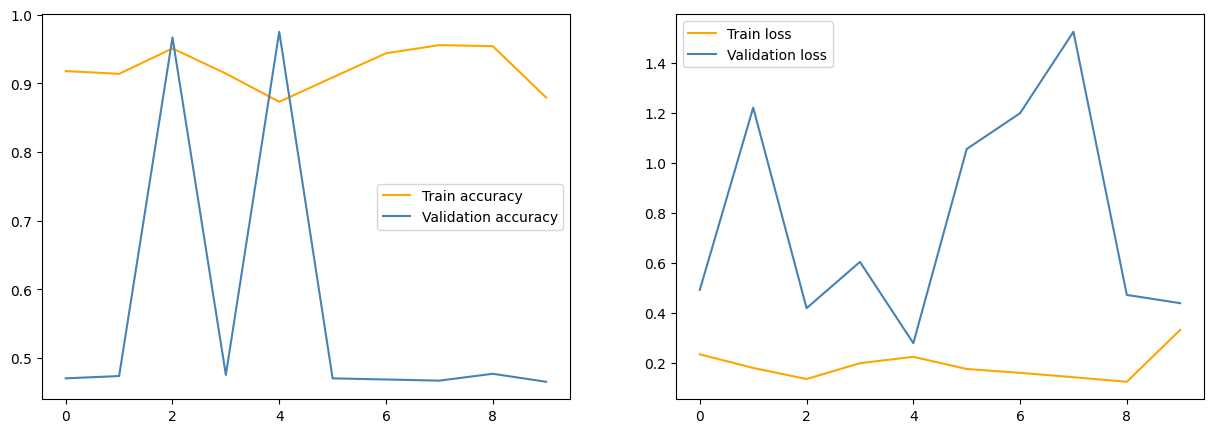

In [1370]:
train_loop(10, 300, 0.001)

Epoch : 1, train accuracy : 0.9571999311447144, train loss : 0.11946497112512589
Epoch : 1, val_accuracy : 0.7149999737739563, val_loss : 1.1600958108901978
Epoch : 2, train accuracy : 0.9370665550231934, train loss : 0.16252121329307556
Epoch : 2, val_accuracy : 0.7274999618530273, val_loss : 1.2013376951217651
Epoch : 3, train accuracy : 0.9382665753364563, train loss : 0.1480456292629242
Epoch : 3, val_accuracy : 0.7199999690055847, val_loss : 1.5561726093292236
Epoch : 4, train accuracy : 0.9466665983200073, train loss : 0.1672784686088562
Epoch : 4, val_accuracy : 0.7299999594688416, val_loss : 1.5374102592468262
Epoch : 5, train accuracy : 0.9571998715400696, train loss : 0.12030444294214249
Epoch : 5, val_accuracy : 0.7174999713897705, val_loss : 1.7051576375961304
Epoch : 6, train accuracy : 0.9660000205039978, train loss : 0.10238399356603622
Epoch : 6, val_accuracy : 0.7324999570846558, val_loss : 1.3497164249420166
Epoch : 7, train accuracy : 0.968000054359436, train loss : 

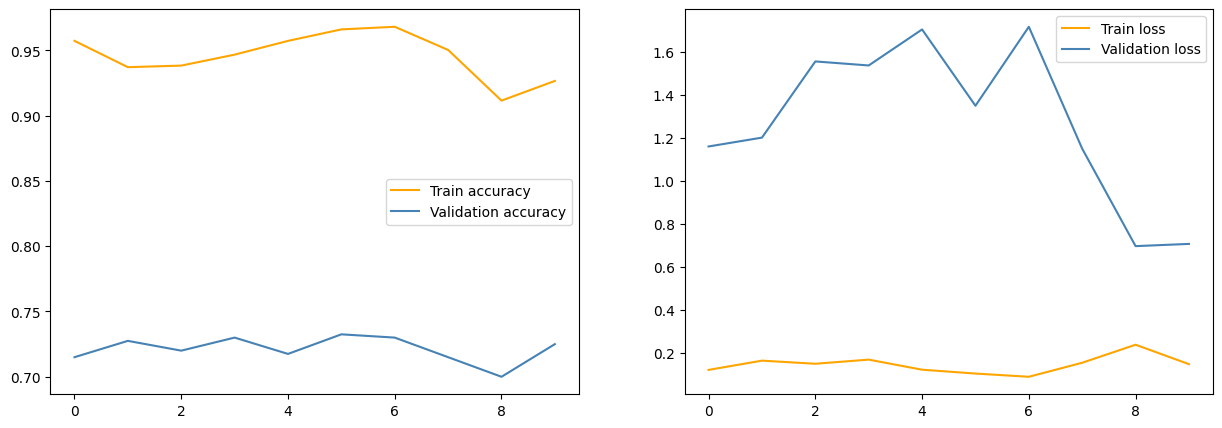

In [1376]:
train_loop(10, 100, 0.005)

Epoch : 1, train accuracy : 0.9420512914657593, train loss : 0.12294825911521912
Epoch : 1, val_accuracy : 0.9675990343093872, val_loss : 0.10286213457584381
Epoch : 2, train accuracy : 0.8842307925224304, train loss : 0.6267232894897461
Epoch : 2, val_accuracy : 0.9577474594116211, val_loss : 0.10390114784240723
Epoch : 3, train accuracy : 0.9274359345436096, train loss : 0.17305731773376465
Epoch : 3, val_accuracy : 0.9402475357055664, val_loss : 0.1517854928970337
Epoch : 4, train accuracy : 0.9351281523704529, train loss : 0.17310398817062378
Epoch : 4, val_accuracy : 0.9626485109329224, val_loss : 0.09668567031621933
Epoch : 5, train accuracy : 0.9526923894882202, train loss : 0.1335313618183136
Epoch : 5, val_accuracy : 0.9675990343093872, val_loss : 0.09780886769294739
Epoch : 6, train accuracy : 0.9378204345703125, train loss : 0.1654118001461029
Epoch : 6, val_accuracy : 0.9700495004653931, val_loss : 0.0772334486246109
Epoch : 7, train accuracy : 0.9170512557029724, train los

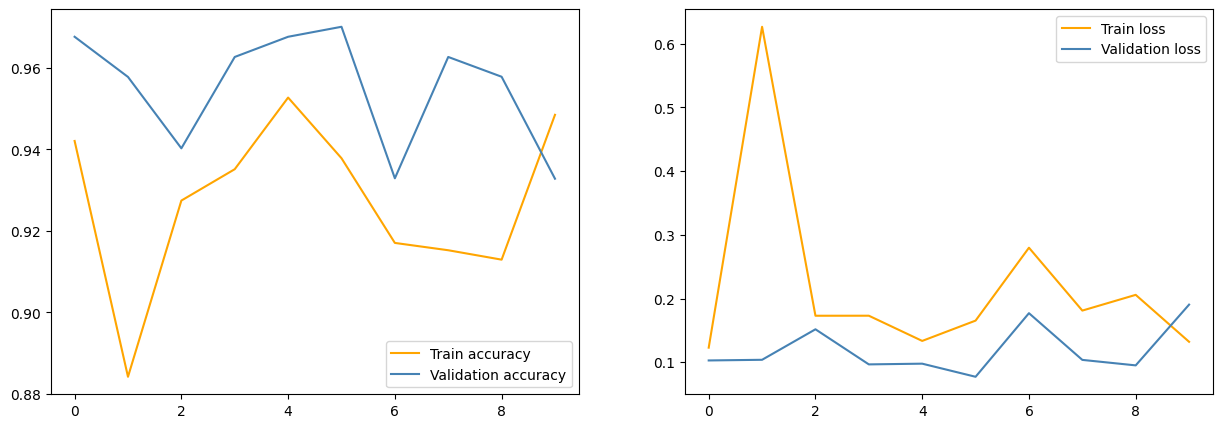

In [1377]:
train_loop(10, 200, 0.005)

Epoch : 1, train accuracy : 0.9637037515640259, train loss : 0.09458014369010925
Epoch : 1, val_accuracy : 0.4833333492279053, val_loss : 2.6258180141448975
Epoch : 2, train accuracy : 0.9714815020561218, train loss : 0.09214264899492264
Epoch : 2, val_accuracy : 0.48500001430511475, val_loss : 1.0044233798980713
Epoch : 3, train accuracy : 0.9703704118728638, train loss : 0.07407603412866592
Epoch : 3, val_accuracy : 0.4883333444595337, val_loss : 2.7763936519622803
Epoch : 4, train accuracy : 0.9722223281860352, train loss : 0.08413350582122803
Epoch : 4, val_accuracy : 0.47833335399627686, val_loss : 1.74417245388031
Epoch : 5, train accuracy : 0.9377779364585876, train loss : 0.14011812210083008
Epoch : 5, val_accuracy : 0.4766666889190674, val_loss : 1.7641351222991943
Epoch : 6, train accuracy : 0.9244445562362671, train loss : 0.1283871978521347
Epoch : 6, val_accuracy : 0.47833335399627686, val_loss : 1.7868175506591797
Epoch : 7, train accuracy : 0.9266667366027832, train loss

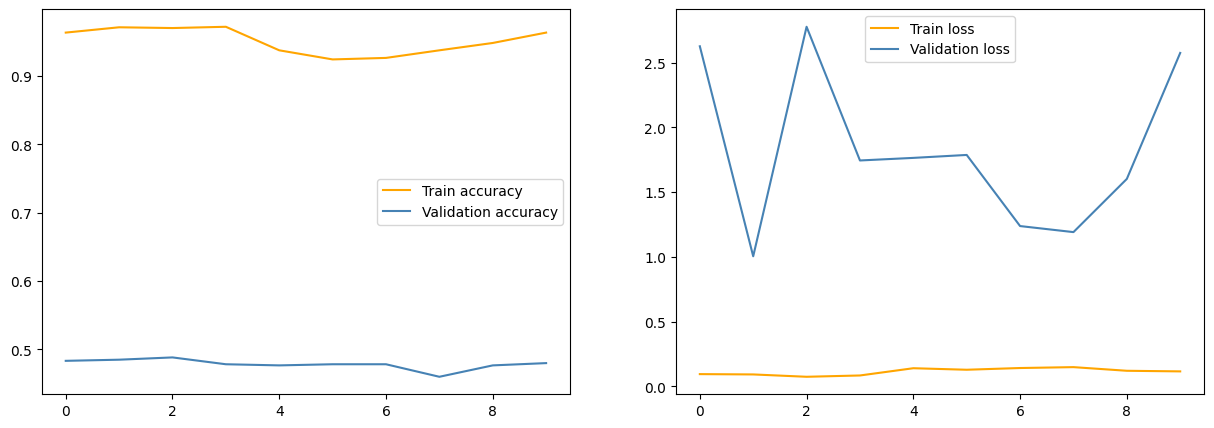

In [1378]:
train_loop(10, 300, 0.005)

Epoch : 1, train accuracy : 0.953999936580658, train loss : 0.13508519530296326
Epoch : 1, val_accuracy : 0.7224999666213989, val_loss : 0.9428294897079468
Epoch : 2, train accuracy : 0.9542666077613831, train loss : 0.09799228608608246
Epoch : 2, val_accuracy : 0.7174999713897705, val_loss : 0.777205228805542
Epoch : 3, train accuracy : 0.938666582107544, train loss : 0.1415162831544876
Epoch : 3, val_accuracy : 0.7149999737739563, val_loss : 1.2865458726882935
Epoch : 4, train accuracy : 0.9380000233650208, train loss : 0.1646197885274887
Epoch : 4, val_accuracy : 0.7249999642372131, val_loss : 0.7872681021690369
Epoch : 5, train accuracy : 0.9534666538238525, train loss : 0.10081544518470764
Epoch : 5, val_accuracy : 0.7174999713897705, val_loss : 0.7062666416168213
Epoch : 6, train accuracy : 0.9479999542236328, train loss : 0.1486382633447647
Epoch : 6, val_accuracy : 0.7224999666213989, val_loss : 0.8363059759140015
Epoch : 7, train accuracy : 0.9441332817077637, train loss : 0.1

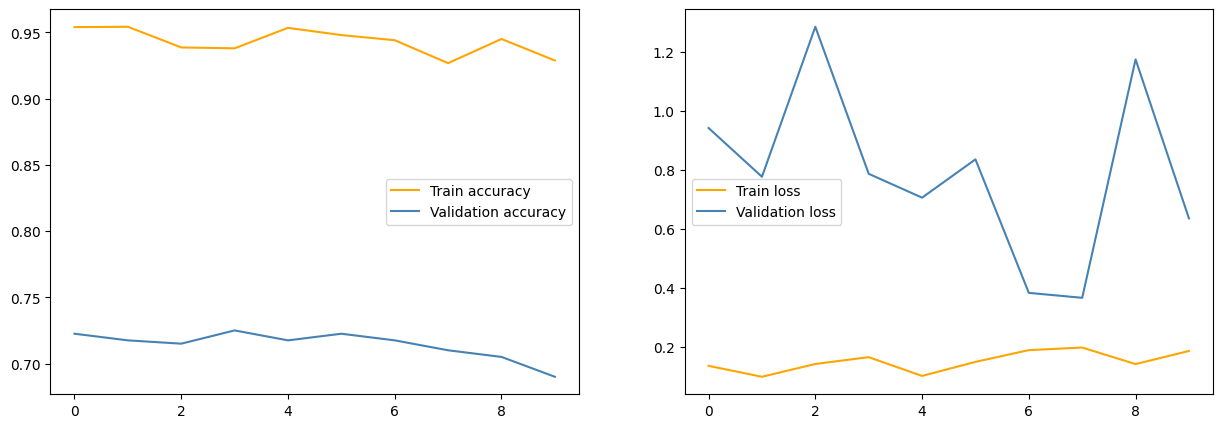

In [1379]:
train_loop(10, 100, 0.008)

Epoch : 1, train accuracy : 0.9588462114334106, train loss : 0.09890614449977875
Epoch : 1, val_accuracy : 0.9551980495452881, val_loss : 0.09971287846565247
Epoch : 2, train accuracy : 0.9703847169876099, train loss : 0.07858312129974365
Epoch : 2, val_accuracy : 0.9800989627838135, val_loss : 0.07129939645528793
Epoch : 3, train accuracy : 0.9742307662963867, train loss : 0.07049974799156189
Epoch : 3, val_accuracy : 0.9676485061645508, val_loss : 0.05924905836582184
Epoch : 4, train accuracy : 0.9680769443511963, train loss : 0.09729354083538055
Epoch : 4, val_accuracy : 0.977599024772644, val_loss : 0.06698682904243469
Epoch : 5, train accuracy : 0.9389743208885193, train loss : 0.11954410374164581
Epoch : 5, val_accuracy : 0.9676485061645508, val_loss : 0.09310188889503479
Epoch : 6, train accuracy : 0.9623076915740967, train loss : 0.10448863357305527
Epoch : 6, val_accuracy : 0.9526485204696655, val_loss : 0.14325200021266937
Epoch : 7, train accuracy : 0.9688461422920227, train

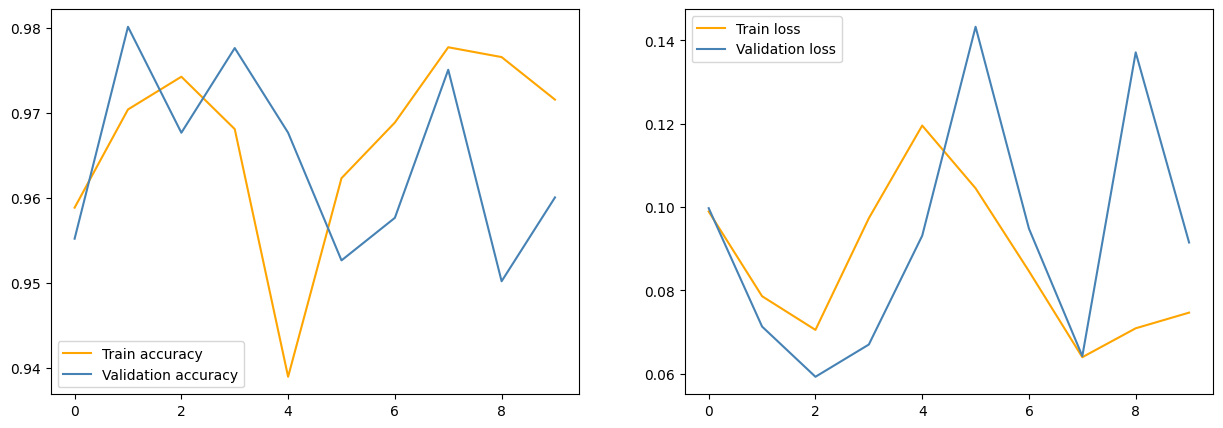

In [1380]:
train_loop(10, 200, 0.008)

Epoch : 1, train accuracy : 0.8836904764175415, train loss : 0.16147446632385254
Epoch : 1, val_accuracy : 0.9501661062240601, val_loss : 0.1378861367702484
Epoch : 2, train accuracy : 0.9710714221000671, train loss : 0.08718341588973999
Epoch : 2, val_accuracy : 0.9700996279716492, val_loss : 0.12459282577037811
Epoch : 3, train accuracy : 0.9703571796417236, train loss : 0.09213129431009293
Epoch : 3, val_accuracy : 0.9534883499145508, val_loss : 0.09385284036397934
Epoch : 4, train accuracy : 0.9750000238418579, train loss : 0.08443453162908554
Epoch : 4, val_accuracy : 0.9634551405906677, val_loss : 0.09159398823976517
Epoch : 5, train accuracy : 0.8822619318962097, train loss : 0.44348374009132385
Epoch : 5, val_accuracy : 0.9568105936050415, val_loss : 0.10338303446769714
Epoch : 6, train accuracy : 0.9407142996788025, train loss : 0.1668592095375061
Epoch : 6, val_accuracy : 0.9269102811813354, val_loss : 0.22508344054222107
Epoch : 7, train accuracy : 0.9521428942680359, train 

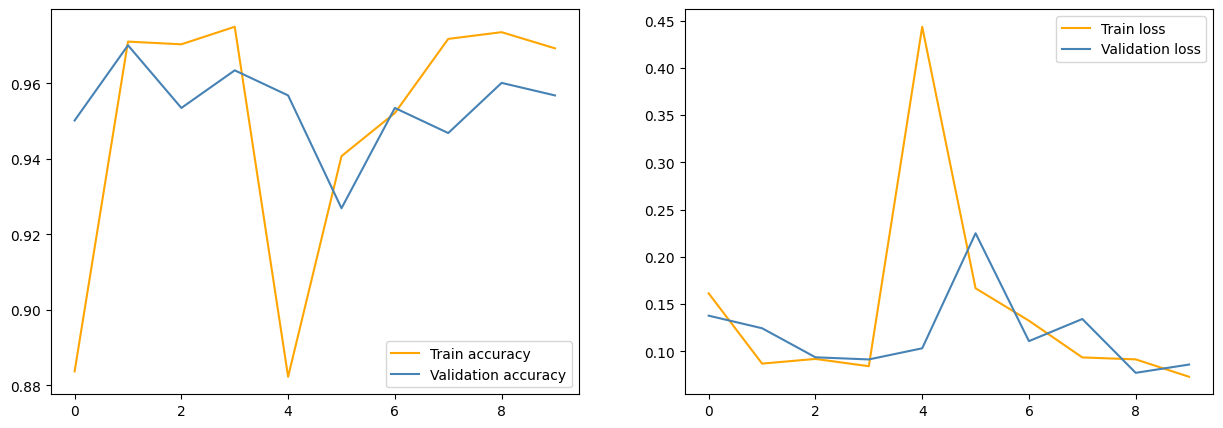

In [1381]:
train_loop(10, 400, 0.008)

Записываем полученные результаты

In [96]:
tiger_probs = []
model.eval()
test_loader = torch.utils.data.DataLoader(
    dataset=test_data, batch_size=100, shuffle=False
)
with torch.no_grad():
    for data, fileid in test_loader:
        data = data.to(device)
        preds = model(data)
        preds_list = functional.softmax(preds, dim=1)[:, 1].tolist()
        tiger_probs += list(zip(list(fileid), preds_list))
tiger_probs.sort(key=lambda x: int(x[0]))
tiger_probs[0:5]

[(tensor(0), 0.45012637972831726),
 (tensor(0), 0.4547955095767975),
 (tensor(0), 0.4540589451789856),
 (tensor(0), 0.45326560735702515),
 (tensor(0), 0.4547796845436096)]

In [97]:
idx = list(map(lambda x: x[0],tiger_probs))
prob = list(map(lambda x: x[1],tiger_probs))
submission = pd.DataFrame({'id':idx,'label':prob})
submission.to_csv('result.csv',index=False)
submission

,id,label
0,tensor(0),0.450126
1,tensor(0),0.454796
2,tensor(0),0.454059
3,tensor(0),0.453266
4,tensor(0),0.454780
...,...,...
295,tensor(1),0.453591
296,tensor(1),0.454044
297,tensor(1),0.455643
298,tensor(1),0.454156


Сохраняем модель

In [98]:
name_model = "model.pt"
torch.save(model.state_dict(), os.path.join("C:/Users/Yana/Documents/python-v6/Lab5", name_model))

Инициаизируем модель и проверяем ее на работоспособность

In [99]:
re_model = Cnn()
re_model.load_state_dict(torch.load(os.path.join("C:/Users/Yana/Documents/python-v6/Lab5", name_model)))

<All keys matched successfully>

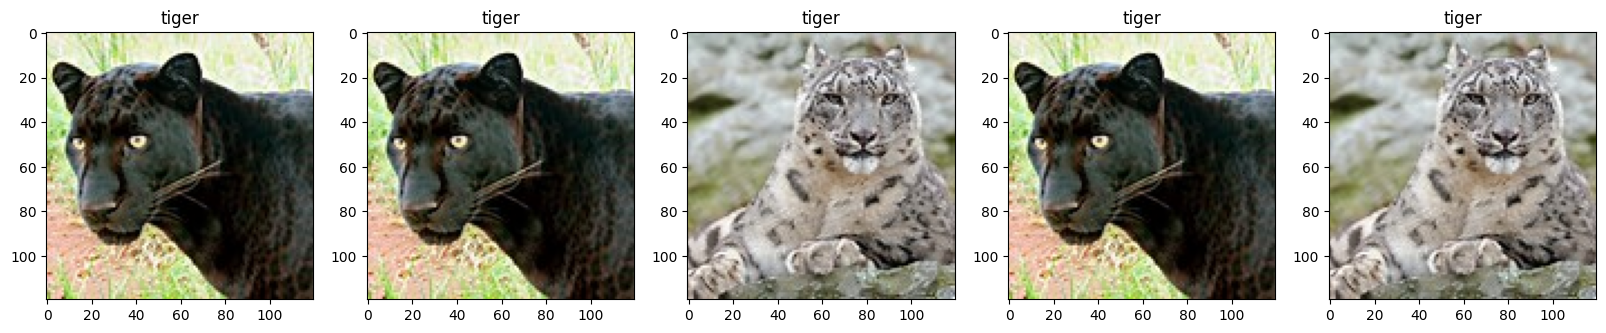

In [115]:
id_list = []

class_ = {0: 'tiger', 1: 'leopard'}

fig, axes = plt.subplots(1, 5, figsize=(20, 12), facecolor='white')

for ax in axes.ravel():
    
    i = random.choice(submission['id'].values)
    
    label = submission.loc[submission['id'] == i, 'label'].values[0]
    if label > 0.5:
        label = 1
    else:
        label = 0
        
    img_path = train_list[i]
    img = Image.open(img_path)
    
    ax.set_title(class_[label])
    ax.imshow(img)
